In [132]:
#modules to load saved models
from joblib import dump, load
from tensorflow.keras.models import load_model

#data preprocessing modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

#regression metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from commons import mean_absolute_percentage_error #keep commons.py in same folder

#classification metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score

#modules for plots if required
import matplotlib.pyplot as plt
%matplotlib inline
from keras.utils import plot_model
from IPython.display import SVG
#from keras.utils import model_to_dot

#get data
#from datacollector import get_data #keep datacollector.py in same folder

# Regression

In [121]:
#df= pd.read_csv('datasets/BTC_Data_736_features_raw.csv',sep=',')
#file path
data=pd.read_csv('datasets/reg_thirty_copy.csv',sep=',')
#data=df[data.columns]

In [122]:
data.shape

(2244, 21)

In [123]:
data.tail()

,activeaddresses,difficulty,difficulty30mom,difficulty30rsi,difficulty90mom,hashrate90var,median_transaction_fee30trxUSD,median_transaction_feeUSD,mining_profitability,mining_profitability90rsi,...,price30wmaUSD,price3emaUSD,price3wmaUSD,price7smaUSD,price90wmaUSD,sentinusd90emaUSD,sentinusd90smaUSD,size90trx,transactionvalueUSD,priceUSD
2239,617851,1.294860e+13,-2.464255e+10,58.535,1.887740e+11,5.860000e+37,-1.108,0.1120,0.137,48.204,...,7256.0,7282.0,7271.0,7314.0,7787.0,8952225768,8130944624,-0.057,19540.0,2240
2240,548303,1.294860e+13,-2.464255e+10,58.535,1.887740e+11,5.850000e+37,-1.149,0.0818,0.145,48.479,...,7259.0,7322.0,7315.0,7336.0,7772.0,8866101420,8132484290,-0.057,16883.0,2241
2241,508034,1.294860e+13,-2.464255e+10,58.535,1.887740e+11,5.840000e+37,-1.194,0.0664,0.144,48.450,...,7270.0,7396.0,7399.0,7364.0,7759.0,8763231772,8079700892,-0.058,14961.0,2242
2242,636443,1.294860e+13,-2.464255e+10,58.535,1.887740e+11,5.850000e+37,-1.241,0.0678,0.152,48.694,...,7276.0,7392.0,7411.0,7344.0,7745.0,8730840664,8053164391,-0.059,22475.0,2243
2243,585047,1.294860e+13,-2.464255e+10,58.535,1.887740e+11,5.870000e+37,-1.287,0.0978,0.135,48.176,...,7276.0,7342.0,7354.0,7334.0,7729.0,8654833019,8034266611,-0.060,17976.0,2244


# LSTM

In [124]:
#create train-test splits for LSTM
length=data.shape[1]-1
X=data.iloc[:,:length]
y=data.iloc[:,length:]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True, random_state=7)
y_train=np.ravel(y_train)
y_test=np.ravel(y_test)
estimators=[]
estimators.append(['robust',RobustScaler()])
estimators.append(['mixmax',MinMaxScaler()])
scaling=Pipeline(estimators)
X_train=scaling.fit_transform(X_train)
X_test=scaling.transform(X_test)
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train=np.reshape(y_train, (y_train.shape[0],1,1))
y_test=np.reshape(y_test,(y_test.shape[0],1,1))

In [125]:
#load saved model
LSTM=load_model('trained_models/LSTM_reg_thirty.hdf5',compile=False)


In [126]:
#make predictions
y_lstm=LSTM.predict(X_test)

In [127]:
y_test=y_test.ravel() #remove [] from y_test
y_lstm=y_lstm.ravel() #remove [] from y_pred

In [128]:
#y_test=np.log(y_test)
#y_lstm=np.log(y_lstm)
#show predictions in tabular format
combine=zip(y_test,y_lstm)
df_lstm=pd.DataFrame(combine,columns=['y_test','y_lstm'])
df_lstm.to_csv('y_n.csv')

In [89]:
#calculate metrics
mae_lstm=mean_absolute_error(y_test,y_lstm)
mape_lstm=mean_absolute_percentage_error(y_test, y_lstm)
rmse_lstm=np.sqrt(mean_squared_error(y_test,y_lstm))
r2_lstm=abs(r2_score(y_test, y_lstm))

In [90]:
#show metrics in tabular format
metrics_lstm=[mae_lstm,mape_lstm,rmse_lstm,r2_lstm]
metrics_labels=['MAE','MAPE','RMSE','R^2']
pd.DataFrame(zip( metrics_labels,metrics_lstm))

,0,1
0,MAE,1958.174527
1,MAPE,146.658874
2,RMSE,3121.643075
3,R^2,22.099514


# SANN

In [91]:
#create train-test splits for SANN
length=data.shape[1]-1
X=data.iloc[:,:length]
y=data.iloc[:,length:]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True, random_state=7)
y_train=np.ravel(y_train)
y_test=np.ravel(y_test)
estimators=[]
estimators.append(['minmax',MinMaxScaler()])
estimators.append(['robust',RobustScaler()])
scaling=Pipeline(estimators)
X_train=scaling.fit_transform(X_train)
X_test=scaling.transform(X_test)

In [92]:
SANN=load_model('trained_models/SANN_reg_thirty.h5',compile=False)

In [93]:
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# make prediction
	return model.predict(X, verbose=1)

In [94]:
#make predictions
y_sann=predict_stacked_model(SANN,X_test)

449/449 [==============================] - 0s 690us/sample


In [95]:
y_sann=y_sann.ravel() #remove [] from y_pred

In [96]:
#show predictions in tabular format
combine=zip(y_test,y_sann)
SANN=pd.DataFrame(combine,columns=['y_test','y_sann'])
SANN.to_csv('sann.csv')

In [97]:
#calculate metrics
mae_sann=mean_absolute_error(y_test,y_sann)
mape_sann=mean_absolute_percentage_error(y_test, y_sann)
rmse_sann=np.sqrt(mean_squared_error(y_test,y_sann))
r2_sann=abs(r2_score(y_test, y_sann))

In [98]:
#show metrics in tabular format
metrics_sann=[mae_sann,mape_sann,rmse_sann,r2_sann]
metrics_labels=['MAE','MAPE','RMSE','R^2']
pd.DataFrame(zip( metrics_labels,metrics_sann))

,0,1
0,MAE,1960.522745
1,MAPE,148.459660
2,RMSE,3137.950330
3,R^2,22.341485


# SVM

In [99]:
#create train-test splits for SVM
length=data.shape[1]-1
X=data.iloc[:,:length]
y=data.iloc[:,length:]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True, random_state=7)
y_train=np.ravel(y_train)
y_test=np.ravel(y_test)
estimators=[]
estimators.append(['standard', StandardScaler()])
scaling=Pipeline(estimators)
X_train=scaling.fit_transform(X_train)
X_test=scaling.transform(X_test)

In [100]:
SVM=load('trained_models/SVM_reg_thirty.joblib')

In [101]:
y_svm=SVM.predict(X_test)

In [102]:
#show predictions in tabular format
combine=zip(y_test,y_svm)
SVM=pd.DataFrame(combine,columns=['y_test','y_svm'])
SVM.to_csv('svm.csv')

In [103]:
#calculate metrics
mae_svm=mean_absolute_error(y_test,y_svm)
mape_svm=mean_absolute_percentage_error(y_test, y_svm)
rmse_svm=np.sqrt(mean_squared_error(y_test,y_svm))
r2_svm=abs(r2_score(y_test, y_svm))

In [104]:
#show metrics in tabular format
metrics_svm=[mae_svm,mape_svm,rmse_svm,r2_svm]
metrics_labels=['MAE','MAPE','RMSE','R^2']
pd.DataFrame(zip( metrics_labels,metrics_svm))

,0,1
0,MAE,1949.628250
1,MAPE,144.727721
2,RMSE,3117.520042
3,R^2,22.038535


# ANN

In [105]:
#create train-test splits for ANN
length=data.shape[1]-1
X=data.iloc[:,:length]
y=data.iloc[:,length:]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True, random_state=7)
y_train=np.ravel(y_train)
y_test=np.ravel(y_test)
estimators=[]
estimators.append(['minmax',MinMaxScaler()])
estimators.append(['robust',RobustScaler()])
scaling=Pipeline(estimators)
X_train=scaling.fit_transform(X_train)
X_test=scaling.transform(X_test)

In [106]:
ANN=load_model('trained_models/ANN_reg_thirty.h5',compile=False)

In [107]:
y_ann=ANN.predict(X_test)

In [108]:
y_ann=y_ann.ravel() #remove [] from y_pred

In [109]:
#show predictions in tabular format
combine=zip(y_test,y_ann)
ANN=pd.DataFrame(combine,columns=['y_test','y_ann'])
ANN.to_csv('ann.csv')

In [110]:
#calculate metrics
mae_ann=mean_absolute_error(y_test,y_ann)
mape_ann=mean_absolute_percentage_error(y_test, y_ann)
rmse_ann=np.sqrt(mean_squared_error(y_test,y_ann))
r2_ann=abs(r2_score(y_test, y_ann))

In [111]:
#show metrics in tabular format
metrics_ann=[mae_ann,mape_ann,rmse_ann,r2_ann]
metrics_labels=['MAE','MAPE','RMSE','R^2']
pd.DataFrame(zip( metrics_labels,metrics_ann))

,0,1
0,MAE,1942.044453
1,MAPE,144.634254
2,RMSE,3111.256432
3,R^2,21.946052


# Plot all

In [143]:
df=pd.read_csv('y_test.csv',header=0)
df.head()

,n,y_test,lstm,ann,sann,svm
0,1,102.694,105.043083,104.006851,115.105286,107.193980
1,2,109.595,112.324692,110.803230,121.607147,104.181577
2,3,110.540,116.102554,122.154060,134.848953,30.957313
3,4,112.241,119.243851,98.058731,113.688538,108.950343
4,5,115.280,118.725494,96.362152,111.320023,116.986814


In [144]:
x=df['n']
#x=np.arange('2020-01-01', '2020-05-10', dtype='datetime64[D]')
y_test=df['y_test']
y_lstm=df['lstm']
y_ann=df['ann']
y_sann=df['sann']
y_svm=df['svm']

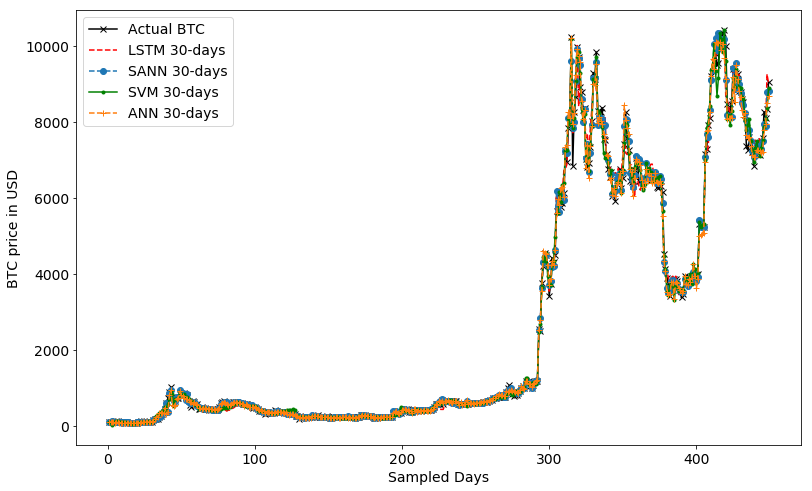

In [151]:
import matplotlib.dates
from matplotlib.dates import DateFormatter
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(111)

# Set major x ticks on Mondays.
#ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.MO))

labels=['Actual BTC price','LSTM Predicted Price']
#plt.xticks(np.arange('2020-01-01', '2020-05-10', 31, dtype='datetime64[D]'))
plt.legend(labels)
ax.plot(x, y_test,'kx-')
ax.plot(x,y_lstm,'r--')
ax.plot(x,y_sann,'o--')
ax.plot(x,y_svm,'g.-')
ax.plot(x,y_ann,'+--')
#ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))

ax.grid(False)

labels=['Actual BTC','LSTM 30-days','SANN 30-days','SVM 30-days','ANN 30-days']
plt.legend(labels)
plt.xlabel('Sampled Days')
plt.ylabel('BTC price in USD')
#plt.title('Prediction on Unseen Data')
plt.savefig('thirty.png',dpi=300,bbox_inches='tight' )
plt.show()